# Download the dataset

In [ ]:
# Install kaggle silently
!pip install kaggle > /dev/null 2>&1

# Setup kaggle credentials silently
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/ > /dev/null 2>&1
!chmod 600 ~/.kaggle/kaggle.json

# Download dataset silently
!kaggle datasets download -d praveengovi/coronahack-chest-xraydataset > /dev/null 2>&1

# Unzip dataset silently
!unzip -q coronahack-chest-xraydataset.zip


chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


# Importing libraries


In [ ]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import random
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image

# Extracting dataset

In [ ]:
extracted_data_path = "Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset"
label_info_path = "Chest_xray_Corona_Metadata.csv"

# Check if the file exists at the given path
if os.path.exists(label_info_path):
    df = pd.read_csv(label_info_path)
    df.head()
else:
    print(f"Error: File not found at {label_info_path}")
    print("Please check if the dataset was correctly unzipped.")
    print("The unzipped folder should contain 'Chest_xray_Corona_Metadata.csv'")

In [ ]:
df.isnull().sum()

,0
Unnamed: 0,0
X_ray_image_name,0
Label,0
Dataset_type,0
Label_2_Virus_category,5841
Label_1_Virus_category,1576


In [ ]:
df

,Unnamed: 0,X_ray_image_name,Label,Dataset_type,Label_2_Virus_category,Label_1_Virus_category
0,0,IM-0128-0001.jpeg,Normal,TRAIN,NaN,NaN
1,1,IM-0127-0001.jpeg,Normal,TRAIN,NaN,NaN
2,2,IM-0125-0001.jpeg,Normal,TRAIN,NaN,NaN
3,3,IM-0122-0001.jpeg,Normal,TRAIN,NaN,NaN
4,4,IM-0119-0001.jpeg,Normal,TRAIN,NaN,NaN
...,...,...,...,...,...,...
5905,5928,person1637_virus_2834.jpeg,Pnemonia,TEST,NaN,Virus
5906,5929,person1635_virus_2831.jpeg,Pnemonia,TEST,NaN,Virus
5907,5930,person1634_virus_2830.jpeg,Pnemonia,TEST,NaN,Virus
5908,5931,person1633_virus_2829.jpeg,Pnemonia,TEST,NaN,Virus


In [ ]:
path_metadata = '../input/coronahack-chest-xraydataset/Chest_xray_Corona_Metadata.csv'
path_train = 'Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train'
path_test = 'Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/test'
path_fasttext = '../input/fasttext-common-crawl-bin-model/cc.en.300.bin'
path_test_img = '../input/coronahack-chest-xraydataset/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train/kjr-21-e24-g003-l-a.jpg'

In [ ]:
df1 = df.copy()
df1.Label_1_Virus_category.fillna(df1.Label, inplace=True)
df1.Label_2_Virus_category.fillna(df1.Label_1_Virus_category,
                                          inplace=True)
df1.drop(['Label', 'Label_1_Virus_category'], axis=1, inplace=True)
df1.rename(columns={'X_ray_image_name':  'Filename',
                            'Dataset_type': 'Type',
                            'Label_2_Virus_category': 'Class'}, inplace=True)
df1.Class.replace({'Virus': 'viral pneumonia',
                           'bacteria': 'bacterial pneumonia',
                           'Normal': 'normal',
                           'COVID-19': 'covid-19'}, inplace=True)
df1

,Unnamed: 0,Filename,Type,Class
0,0,IM-0128-0001.jpeg,TRAIN,normal
1,1,IM-0127-0001.jpeg,TRAIN,normal
2,2,IM-0125-0001.jpeg,TRAIN,normal
3,3,IM-0122-0001.jpeg,TRAIN,normal
4,4,IM-0119-0001.jpeg,TRAIN,normal
...,...,...,...,...
5905,5928,person1637_virus_2834.jpeg,TEST,viral pneumonia
5906,5929,person1635_virus_2831.jpeg,TEST,viral pneumonia
5907,5930,person1634_virus_2830.jpeg,TEST,viral pneumonia
5908,5931,person1633_virus_2829.jpeg,TEST,viral pneumonia


In [ ]:
df1.shape

(5910, 4)

In [ ]:
df1['Class'].value_counts()

,count
Class,
bacterial pneumonia,2772
normal,1576
viral pneumonia,1493
covid-19,58
Streptococcus,5
SARS,4
ARDS,2


In [ ]:
# dataframes (training, validation, testing)
df_train = df1[(df1.Type == 'TRAIN')]
df_test = df1[(df1.Type == 'TEST').reset_index(drop=True)]

# df_zsl = df[(df.Class.isin(class_zsl))].reset_index(drop=True)

In [ ]:
df_train.head()

,Unnamed: 0,Filename,Type,Class
0,0,IM-0128-0001.jpeg,TRAIN,normal
1,1,IM-0127-0001.jpeg,TRAIN,normal
2,2,IM-0125-0001.jpeg,TRAIN,normal
3,3,IM-0122-0001.jpeg,TRAIN,normal
4,4,IM-0119-0001.jpeg,TRAIN,normal


In [ ]:
df_train.drop(['Type','Unnamed: 0'], axis=1, inplace=True)
df_test.drop(['Type','Unnamed: 0'], axis=1, inplace=True)
# df_jsl.drop(['Type','Unnamed: 0'], axis=1, inplace=True)

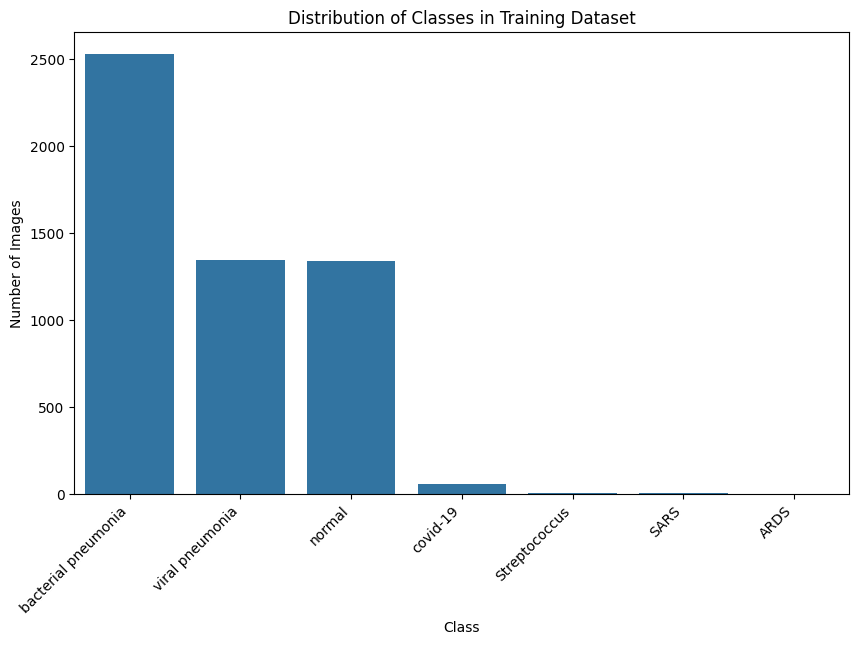

In [ ]:


# Count the occurrences of each class
class_counts = df_train['Class'].value_counts()

# Create a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.title('Distribution of Classes in Training Dataset')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.show()

In [ ]:
# Assuming df_train is already defined from the previous code
selected_classes = ['bacterial pneumonia', 'viral pneumonia', 'normal']
df_train = df_train[df_train['Class'].isin(selected_classes)]

df_train

,Filename,Class
0,IM-0128-0001.jpeg,normal
1,IM-0127-0001.jpeg,normal
2,IM-0125-0001.jpeg,normal
3,IM-0122-0001.jpeg,normal
4,IM-0119-0001.jpeg,normal
...,...,...
5212,person88_virus_167.jpeg,viral pneumonia
5213,person88_virus_166.jpeg,viral pneumonia
5214,person88_virus_165.jpeg,viral pneumonia
5215,person88_virus_164.jpeg,viral pneumonia


In [ ]:
X_train = df_train['Filename']
y_train = df_train['Class']
X_test = df_test['Filename']
y_test = df_test['Class']

In [ ]:
idg_train = image.ImageDataGenerator(rescale=1/255, rotation_range=10,
                                     zoom_range=[0.75, 1],
                                     brightness_range=(0.8, 1.2) )
idg_test = image.ImageDataGenerator(rescale=1/255)

data_train = idg_train.flow_from_dataframe(dataframe=df_train,
                                           directory=path_train,
                                           x_col='Filename',
                                           y_col='Class',
                                           target_size=(224, 224),
                                           batch_size=32,
                                           shuffle=True,
                                           class_mode='categorical')
data_test = idg_test.flow_from_dataframe(dataframe=df_test,
                                          directory=path_test,
                                          x_col='Filename',
                                          y_col='Class',
                                          target_size=(224, 224),
                                          batch_size=32,
                                          shuffle=True,
                                          class_mode='categorical')




Found 5217 validated image filenames belonging to 3 classes.
Found 624 validated image filenames belonging to 3 classes.


In [ ]:
# prompt: split data train
from sklearn.model_selection import train_test_split
# Assuming df_train is your training dataframe with 'Filename' and 'Class' columns
# Split the data into training and validation sets
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    df_train['Filename'], df_train['Class'], test_size=0.2, random_state=42
)  # Adjust test_size as needed

# Create new dataframes for the split data
df_train_split = pd.DataFrame({'Filename': X_train_split, 'Class': y_train_split})
df_val_split = pd.DataFrame({'Filename': X_val_split, 'Class': y_val_split})

# Now you have df_train_split and df_val_split for training and validation, respectively
# You can use these dataframes in your image data generators:

idg_train = image.ImageDataGenerator(rescale=1/255, rotation_range=10,
                                     zoom_range=[0.75, 1],
                                     brightness_range=(0.8, 1.2))

idg_val = image.ImageDataGenerator(rescale=1/255) # Use rescale for validation data

data_train_split = idg_train.flow_from_dataframe(dataframe=df_train_split,
                                           directory=path_train,
                                           x_col='Filename',
                                           y_col='Class',
                                           target_size=(224, 224),
                                           batch_size=32,
                                           shuffle=True,
                                           class_mode='categorical')

data_val_split = idg_val.flow_from_dataframe(dataframe=df_val_split,
                                          directory=path_train,
                                          x_col='Filename',
                                          y_col='Class',
                                          target_size=(224, 224),
                                          batch_size=32, #Can adjust batch size
                                          shuffle=False, #Important: No shuffling for validation
                                          class_mode='categorical')



Found 4173 validated image filenames belonging to 3 classes.
Found 1044 validated image filenames belonging to 3 classes.


In [ ]:
# prompt: check how many images are in the train and val

print("Number of images in the training set:", len(df_train_split))
print("Number of images in the validation set:", len(df_val_split))

Number of images in the training set: 4173
Number of images in the validation set: 1044


In [ ]:
data_val_split.class_indices

{'bacterial pneumonia': 0, 'normal': 1, 'viral pneumonia': 2}

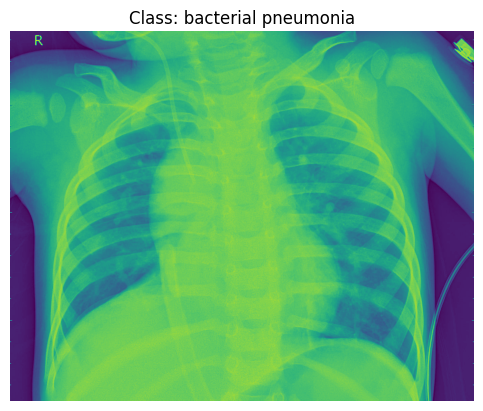

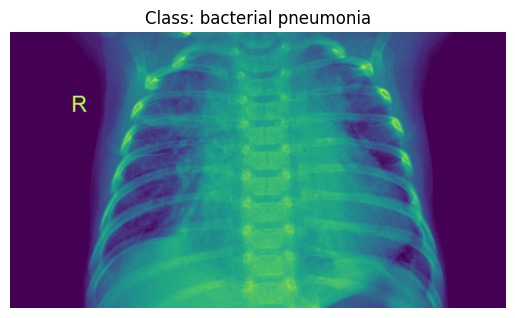

In [ ]:
def load_and_display_random_image(df, path):
  """Loads and displays a random image from the specified dataset."""

  # Choose a random index from the DataFrame
  random_index = random.randint(0, len(df) - 1)

  # Get the filename and class from the DataFrame
  filename = df.iloc[random_index]['Filename']
  class_label = df.iloc[random_index]['Class']

  # Construct the image path
  image_path = os.path.join(path, filename)

  # Load the image using matplotlib
  try:
      img = plt.imread(image_path)
      plt.imshow(img)
      plt.title(f"Class: {class_label}")
      plt.axis('off') # Hide axis ticks and labels
      plt.show()

  except FileNotFoundError:
      print(f"Error: Image file not found at {image_path}")

# Example usage for the training dataset:
load_and_display_random_image(df_train, path_train)

# Example usage for the testing dataset:
load_and_display_random_image(df_test, path_test)

In [ ]:
data_train.class_indices

{'bacterial pneumonia': 0, 'normal': 1, 'viral pneumonia': 2}

# Hypertuning VGG19

In [ ]:
import numpy as np
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasClassifier
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG19
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

# Define your model-building function
def create_vgg19_model(input_shape=(224, 224, 3), num_classes=3, learning_rate=0.0001, dropout_rate=0.5, dense_units=512):
    base_model = VGG19(weights="imagenet", include_top=False, input_shape=input_shape)
    base_model.trainable = False

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dropout(dropout_rate),
        layers.Dense(dense_units, activation="relu"),
        layers.Dropout(dropout_rate),
        layers.Dense(num_classes, activation="softmax")
    ])

    model.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate=learning_rate), metrics=["accuracy"])
    return model

# Wrap the model
model = KerasClassifier(model=create_vgg19_model, input_shape=(224, 224, 3), num_classes=3, epochs=30, batch_size=32)

# Hyperparameter tuning
param_grid = {
    'model__learning_rate': [0.0001, 0.00001],
    'model__dropout_rate': [0.3, 0.5],
    'model__dense_units': [256, 512],
    'batch_size': [32, 64],
    'epochs': [20, 30]
}

# Dummy data to test (replace with actual training data)
X_train = np.random.random((100, 224, 224, 3))
y_train = np.random.randint(0, 3, size=(100,))
y_train = to_categorical(y_train, num_classes=3)  # One-hot encode the labels

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3)

# Fit the GridSearchCV
grid_search.fit(X_train, y_train)

# Print the best parameters
print("Best Parameters:", grid_search.best_params_)


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.4233 - loss: 1.2435
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.3192 - loss: 1.2478 
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.2614 - loss: 1.2577 
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.3073 - loss: 1.1617 
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.3691 - loss: 1.1850 
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.3344 - loss: 1.2162 
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.4309 - loss: 1.1542 
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.4233 - loss: 1.1109 
Epoch 9/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.4577 - loss: 1.0050 
Epoch 10/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.3542 - loss: 1.1837 
Epoch 11/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.3192 - loss: 1.1886 
Epoch 12/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.3078 - loss: 

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 403ms/step
Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 606ms/step - accuracy: 0.4001 - loss: 1.2108
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.2653 - loss: 1.4641 
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.3459 - loss: 1.2730 
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.4502 - loss: 1.1658 
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.3918 - loss: 1.3121 
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.4311 - loss: 1.2021 
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.3767 - loss: 1.3372 
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.3923 - loss: 1.2375 
Epoch 9/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.3151 - loss: 1.3924 
Epoch 10/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.3652 - loss: 1.2884 
Epoch 11/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.3117 - loss: 1.2253 
Epoch 12/20
3/3 ━━━━━━━━━━━━━━━━━━━

In [ ]:
# Get the best trained model from the GridSearchCV estimator
best_model = grid_search.best_estimator_.model_

# Save the best model
best_model.save("best_vgg19_model_hypertuned.h5")
print("Model saved as best_vgg19_model_hypertuned.h5")
best_model.save('best_vgg19_model_hypertuned.keras')



Model saved as best_vgg19_model_hypertuned.h5
